In [62]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [63]:
df_ETTh1 = pd.read_csv("ETDataset/ETT-small/final_surgeries.csv")

In [64]:
df_ETTh1.head()
x_y = df_ETTh1.iloc[:,:]
a=x_y.shape[0]
print(a*0.8,a*0.9,a)

529274.4 595433.7000000001 661593


In [65]:
nan_count = df_ETTh1.isna().sum().sum()
print("Number of NaN values:", nan_count)

Number of NaN values: 0


In [66]:
class ETTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset="final_surgeries", mode="train", scale=False, seq_len=1, pred_len=1):       #336,96
        super().__init__()
        df = pd.read_csv("ETDataset/ETT-small/{}.csv".format(dataset))
        x_y = df.iloc[:,:]  ###################################

        self.len = x_y.shape[0]

        time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]
        
        self.seq_len = seq_len
        self.pred_len = pred_len

        # border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        # border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

        border1s = [0, (529274) - self.seq_len,  595433 - self.seq_len]
        border2s = [529274, 595433, 661593-1]


        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        if scale:
            train_x_y = x_y.iloc[border1s[0]: border2s[0]]
            self.ss = StandardScaler()
            self.ss.fit(train_x_y.to_numpy(dtype=np.float32))
            x_y = self.ss.transform(x_y.to_numpy(dtype=np.float32))
        else:
            x_y = x_y.to_numpy(dtype=np.float32)
        
        time_stamp = time_stamp.to_numpy()     
        
        self.data_x = x_y[border1: border2, :4]      ###################################################################################
        print(self.data_x.shape, "x")
        self.data_y = x_y[border1: border2, -1]     ###################################################################################
        print(self.data_y.shape, "y")

        self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.ss.inverse_transform(data)

In [67]:
#implementation of utils
class RevIN(torch.nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False, target_idx=-1):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.target_idx = target_idx
        if self.affine:
            self._init_params()

    def forward(self, x, mode):
        if mode == "norm":
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else: raise AssertionError
        return x

    def _init_params(self):
        self.affine_weight = torch.nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = torch.nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev[:, :, self.target_idx]
        if self.subtract_last:
            x = x + self.last[:, :, self.target_idx]
        else:
            x = x + self.mean[:, :, self.target_idx]
        return x


class Transpose(torch.nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: 
            return x.transpose(*self.dims).contiguous()
        else: 
            return x.transpose(*self.dims)


def positional_encoding(q_len, d_model):
    W_pos = torch.empty((q_len, d_model))
    torch.nn.init.uniform_(W_pos, -0.02, 0.02)
    return torch.nn.Parameter(W_pos, requires_grad=True)

In [68]:
#Implementation of PatchTST Encorder layer
class TSTiEncoder(torch.nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 verbose=False, **kwargs):
        super().__init__()
        self.patch_num = patch_num
        self.patch_len = patch_len
        # Input encoding
        q_len = patch_num
        self.W_P = torch.nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len
        # Positional encoding
        self.W_pos = positional_encoding(q_len, d_model)
        # Residual dropout
        self.dropout = torch.nn.Dropout(dropout)
        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)

    def forward(self, x):                                              # x: [bs x nvars x patch_len x patch_num]
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]
        
        return z       
            
    
# Cell
class TSTEncoder(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, 
                        norm='BatchNorm', attn_dropout=0., dropout=0., 
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = torch.nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src, key_padding_mask=None, attn_mask=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: 
                output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: 
                output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = torch.nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = torch.nn.Sequential(torch.nn.Linear(d_model, d_ff, bias=bias),
                                torch.nn.GELU(),
                                torch.nn.Dropout(dropout),
                                torch.nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = torch.nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src, prev=None, key_padding_mask=None, attn_mask=None):

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src
        

class _MultiheadAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = torch.nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = torch.nn.Sequential(torch.nn.Linear(n_heads * d_v, d_model), torch.nn.Dropout(proj_dropout))

    def forward(self, Q, K=None, V=None, prev=None,
                key_padding_mask=None, attn_mask=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = torch.nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = torch.nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q, k, v, prev=None, key_padding_mask=None, attn_mask=None):
        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [69]:
#Implementation of head layer

class Flatten_Head(torch.nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = torch.nn.Flatten(start_dim=-3)
        self.linear = torch.nn.Linear(nf * n_vars, target_window) 
        self.dropout = torch.nn.Dropout(head_dropout)
            
    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)                               # x: [bs x nvars * d_model * patch_num]
        x = self.linear(x)                                # x: [bs x target_window]
        x = self.dropout(x)
        return x
        

In [70]:
#Implementation of PatchTST

class PatchTST(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, max_seq_len=1024, 
                 n_layers=3, d_model=16, n_heads=4, d_k=None, d_v=None,
                 d_ff=128, attn_dropout=0.0, dropout=0.3, key_padding_mask='auto',
                 padding_var=None, attn_mask=None, res_attention=True, pre_norm=False, store_attn=False,
                 head_dropout = 0.0, padding_patch = "end",
                 revin = True, affine = False, subtract_last = False,
                 verbose=False, target_idx=-1, **kwargs):
        super().__init__()

        self.revin = revin
        if revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last, target_idx=target_idx)

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)

        if padding_patch == "end":
            self.padding_patch_layer = torch.nn.ReplicationPad1d((0, stride))
            patch_num += 1

        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                verbose=verbose, **kwargs)
        
        self.head_nf = d_model * patch_num
        self.n_vars = c_in

        self.head = Flatten_Head(self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)
        
    def forward(self, z):                                                                   # z: [bs x seq_len × nvars]
        # instance norm
        if self.revin:                                                        
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)                                                            # z: [bs x nvars × seq_len]
            
        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]
        
        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x target_window] 
        
        # denorm
        if self.revin:                                                        
            z = self.revin_layer(z, 'denorm')
        return z


In [71]:
#Linear model
class Linear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        self.c_in = c_in
        self.context_winsoq = context_window
        self.target_window = target_window

        self.flatten = torch.nn.Flatten(start_dim=-2)

        self.linear = torch.nn.Linear(c_in * context_window, target_window)
    
    def forward(self, x):                   # x: [bs x seq_len × nvars]
        x = self.flatten(x)                 # x: [bs x seq_len * nvars]
        x = self.linear(x)                  # x: [bs x target_window]
        return x
    

class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.flatten_Seasonal = torch.nn.Flatten(start_dim=-2)
        self.flatten_Trend = torch.nn.Flatten(start_dim=-2)
        
        self.Linear_Seasonal = torch.nn.Linear(c_in * context_window, target_window)
        self.Linear_Trend = torch.nn.Linear(c_in * context_window, target_window)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init = self.flatten_Seasonal(x)
        trend_init = self.flatten_Trend(x)

        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x


In [72]:
from tqdm import tqdm
import torch
import numpy as np

class Learner:
    def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, d_model=16, adjust_lr=True, adjust_factor=0.001, context_window=336, target_window=96):
        self.model = model
        self.batch_size = batch_size
        train_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="train")
        valid_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="val")
        test_dataset = dataset(seq_len=context_window, pred_len=target_window, mode="test")
        self.train_datalen = len(train_dataset)
        self.valid_datalen = len(valid_dataset)
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.L1Loss()
        self.epochs = epochs
        self.target_window = target_window
        self.best_weight = self.model.state_dict()
        self.d_model = d_model
        self.adjust_lr = adjust_lr
        self.adjust_factor = adjust_factor
    
    def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout: 
            print('Updating learning rate to {}'.format(lr_adjust))
        return 

    def train(self):
        best_valid_loss = np.inf
        train_history = []
        valid_history = []
        test_history = []
        train_steps = 1
        if self.adjust_lr:
            self.adjust_learning_rate(train_steps)

        # Overall epoch progress bar
        epoch_bar = tqdm(total=self.epochs, desc="Total Epochs", position=0)
        for epoch in range(self.epochs):
            #print(f"epoch: {epoch + 1}/{self.epochs}")
            # train
            self.model.train()
            iter_count = 0
            total_loss = 0

            # Epoch progress bar
            train_bar = tqdm(total=len(self.train_dataloader), desc=f"Batch % of epoch  {epoch + 1}/{self.epochs}", position=0)
            
            for train_x, train_y in self.train_dataloader:
                train_x = train_x
                train_y = train_y
                
                pred_y = self.model(train_x)
                loss = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                iter_count += 1
                train_steps += 1

                train_bar.set_postfix(loss=loss.item())
                train_bar.update(1)
            
            train_bar.close()
                
            if self.adjust_lr:
                self.adjust_learning_rate(train_steps)

            # valid
            self.model.eval()
            valid_iter_count = 0
            valid_total_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x
                    valid_y = valid_y
                    pred_y = self.model(valid_x)
                    loss = self.loss(pred_y, valid_y)
                    valid_total_loss += loss.item()
                    valid_iter_count += 1
            
            total_loss /= iter_count
            valid_total_loss /= valid_iter_count
            print(f"epoch: {epoch + 1}/{self.epochs} MAE loss: {total_loss:.4f} MAE valid loss: {valid_total_loss:.4f}")
            if best_valid_loss >= valid_total_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = valid_total_loss
                print("Best score! Weights of the model are updated!")
            train_history.append(total_loss)
            valid_history.append(valid_total_loss)

            # Update the overall epoch progress bar
            epoch_bar.update(1)
        
        epoch_bar.close()
        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0
        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x
                test_y = test_y
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1
        total_loss /= iter_count
        print(f"MAE test loss: {total_loss:.4f}")
        return total_loss
        


In [73]:
# c_in = 4
# context_window = 336
# target_window = 96
# patch_len = 16
# stride = 8 

c_in = 4
context_window = 120
target_window = 1
patch_len = 20
stride = 20
scale = False

batch_size = 50000

In [74]:
patchtst_model = PatchTST(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride)

In [75]:
Linear_model = Linear(c_in=c_in, context_window=context_window, target_window=target_window)
DLinear_model = DLinear(c_in=c_in, context_window=context_window, target_window=target_window)

In [76]:
Linear_learner = Learner(model=Linear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01, context_window =context_window , target_window =target_window, batch_size = batch_size)
DLinear_learner = Learner(model=DLinear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01, context_window =context_window, target_window=target_window, batch_size = batch_size)
patchtst_learner = Learner(model=patchtst_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.001, context_window =context_window , target_window=target_window, batch_size = batch_size)

(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y
(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y
(529274, 4) x
(529274,) y
(66279, 4) x
(66279,) y
(66279, 4) x
(66279,) y


In [77]:
#patchtst_train_history, patchtst_valid_history = patchtst_learner.train()

In [78]:
#Linear_train_history, Linear_valid_history = Linear_learner.train()

In [79]:
#DLinear_train_history, DLinear_valid_history = DLinear_learner.train()

In [80]:
# import concurrent.futures

# # Define the training function to be used in parallel
# def train_learner(learner):
#     return learner.train()

# # Run the training processes in parallel
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     patchtst_future = executor.submit(train_learner, patchtst_learner)
#     linear_future = executor.submit(train_learner, Linear_learner)
#     dlinear_future = executor.submit(train_learner, DLinear_learner)

#     patchtst_train_history, patchtst_valid_history = patchtst_future.result()
#     Linear_train_history, Linear_valid_history = linear_future.result()
#     DLinear_train_history, DLinear_valid_history = dlinear_future.result()





In [81]:
# patchtst_train_history, patchtst_valid_history = patchtst_future.result()
# Linear_train_history, Linear_valid_history = linear_future.result()
# DLinear_train_history, DLinear_valid_history = dlinear_future.result()

In [82]:
# Linear_test_loss = Linear_learner.test()

In [83]:
# DLinear_test_loss = DLinear_learner.test()

In [84]:
# patchtst_test_loss = patchtst_learner.test()

In [85]:
# import pickle
# model = patchtst_learner.model
# with open('patch_tst_model.pkl', 'wb') as file:
#     pickle.dump(model, file)
# print("Model saved successfully as 'patch_tst_model.pkl'.")


# model = Linear_learner.model
# with open('Linear_learner.pkl', 'wb') as file:
#     pickle.dump(model, file)
# print("Model saved successfully as 'Linear_learner.pkl'.")


# model = DLinear_learner.model
# with open('DLinear_learner.pkl', 'wb') as file:
#     pickle.dump(model, file)
# print("Model saved successfully as 'DLinear_learner.pkl'.")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, patchtst_learner.epochs+1), patchtst_valid_history, label="PatchTST")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(8, 10)
ax.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, Linear_learner.epochs+1), Linear_valid_history, label="Linear")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(8, 70)
ax.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, DLinear_learner.epochs+1), DLinear_valid_history, label="DLinear")
ax.set_xlabel("epochs")
ax.set_ylabel("MAE Error")
ax.set_ylim(9, 17.5)
ax.legend()
fig.show()

In [ ]:
######################################### FOR TESTING  ###################################################################################

In [87]:
test_dataset = ETTDataset(seq_len=120, pred_len=1, mode="test")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(66279, 4) x
(66279,) y


In [88]:
import pickle

with open('Linear_learner.pkl', 'rb') as file:
    Linear_learner = pickle.load(file)
    
with open('patch_tst_model.pkl', 'rb') as file:
    patch_tst = pickle.load(file)
    
with open('DLinear_learner.pkl', 'rb') as file:
    DLinear_learner = pickle.load(file)



In [89]:
x_y = df_ETTh1.iloc[:,:]
a=x_y.shape[0]
print(a*0.8,a*0.9,a)

529274.4 595433.7000000001 661593


In [90]:
X_test = df_ETTh1.iloc[:120,0:4]

In [91]:
y_test = df_ETTh1.iloc[int(a*0.9)//1:int(a//1)-1,3]

In [92]:
Xtest = torch.tensor(X_test.values).unsqueeze(0)
Xtest = Xtest.to(torch.float32)
Xtest.shape

torch.Size([1, 120, 4])

In [93]:
ytest = torch.tensor(y_test.values).unsqueeze(0)
ytest.shape

torch.Size([1, 66159])

In [94]:
patchtst(Xtest)

tensor([[36.1904]], grad_fn=<AddBackward0>)

torch.Size([50000, 1]) torch.Size([50000, 1])
11.215527534484863
torch.Size([16159, 1]) torch.Size([16159, 1])
9.18646764755249


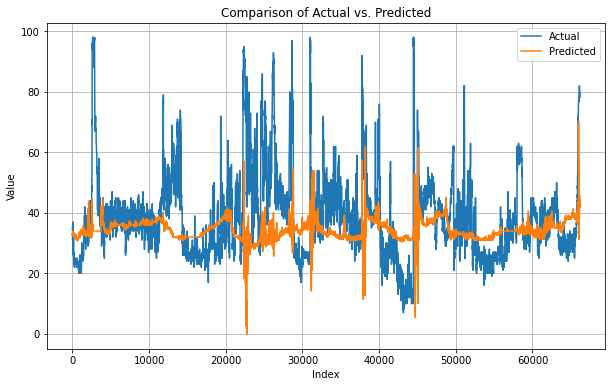

0

In [95]:
def plotter(model):
    loss_ = torch.nn.L1Loss()
    total_loss = 0
    iter_count = 0
    y_ = []
    y = []
    for test_x, test_y in test_dataloader:
            y.append(test_y)
            test_x = test_x
            test_y = test_y
            pred_y = model(test_x)
            y_.append(pred_y)
            loss = loss_(pred_y, test_y)
            print(pred_y.shape, test_y.shape)
            total_loss += loss.item()
            iter_count += 1
            print(total_loss/iter_count)

    y_pred = torch.cat(y_, dim=0)
    y_test = torch.cat(y, dim=0)


    import matplotlib.pyplot as plt
    assert len(y_pred) == len(y_test), "Length of y_pred and y_test must be the same"

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.detach().numpy(), label='Actual')
    plt.plot(y_pred.detach().numpy(), label='Predicted')
    plt.title('Comparison of Actual vs. Predicted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    return 0

plotter(patchtst)

torch.Size([50000, 1]) torch.Size([50000, 1])
10.672385215759277
torch.Size([16159, 1]) torch.Size([16159, 1])
10.11697244644165


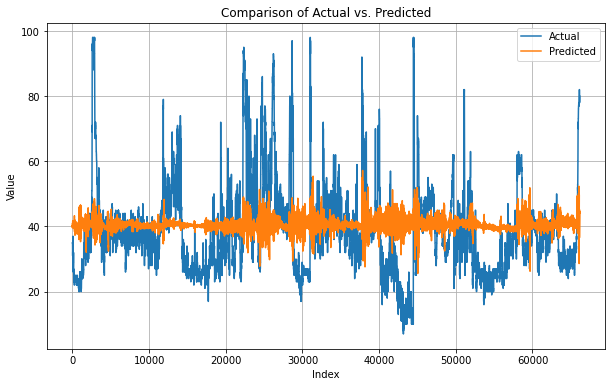

0

In [96]:
plotter(DLinear_learner)

torch.Size([50000, 1]) torch.Size([50000, 1])
10.765107154846191
torch.Size([16159, 1]) torch.Size([16159, 1])
10.195148468017578


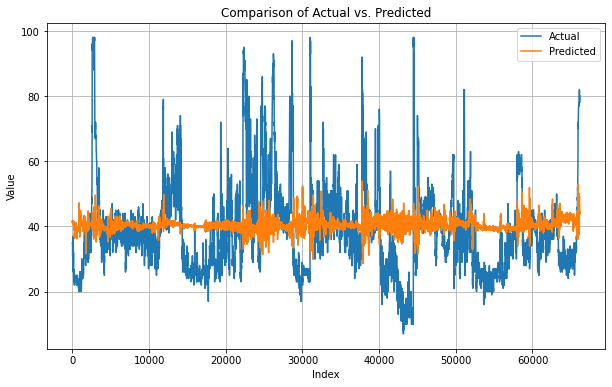

0

In [99]:
plotter(Linear_learner)